In [148]:
import numpy as np
import urllib.request
import scipy.io
import os.path
import matplotlib.pyplot as plt

In [161]:
def lire_alpha_digit(index=list(range(10, 11))):
    """Read the database Binary AlphaDigits

    Parameters
    ----------
    index : a list of index of characters,
        By default list(range(10, 20)), i.e. from 'A' to 'J'

    Returns
    -------
    numpy.ndarray
        Extracted data in matrix form: (n_samples, n_pixels)
    """
    filename = "binaryalphadigs.mat"
    if not os.path.isfile(filename):
        url = "https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat"
        urllib.request.urlretrieve(url, filename)
        print("Data Binary AlphaDigits is downloaded!")
    print("Loading data...")
    mat = scipy.io.loadmat("binaryalphadigs.mat")['dat']
    print("Finished!")
    mat = mat[index]
    data = [x.flatten() for i in range(len(index)) for x in mat[i]]
    return np.array(data)

In [162]:
all_data = lire_alpha_digit()

Loading data...
Finished!


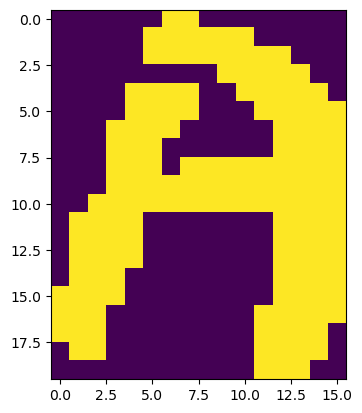

In [163]:
plt.imshow(all_data[0].reshape(20, 16), interpolation='none')
plt.show()

In [34]:
class RBM():
    def __init__(self, a, b, w) -> None:
        self.a = a
        self.b = b
        self.w = w

In [35]:
def init_RBM(p, q):
    """Initiate the parameters in RBM

    Parameters
    ----------
    p : int
        Number of neurones in visible layer
    q : int
        Number of neurones in hidden layer

    Returns
    -------
    instance of RBM class
    """
    a = np.zeros(p)
    b = np.zeros(q)
    w = np.random.normal(loc=0, scale=np.sqrt(0.01), size=(p, q))
    return RBM(a, b, w)

In [120]:
def entree_sortie_RBM(data_in, rbm):
    """From visible layer to hidden layer

    Parameters
    ----------
    data_in : numpy.ndarray: (n_samples, n_neurones_visible)
        visible data
    rbm : instance of RBM class
        a RBM structure

    Returns
    -------
    numpy.ndarray: (n_samples, n_neurones_hidden)
        p(h | data_in)
    """
    return 1 / (1 + np.exp(-(data_in @ rbm.w + rbm.b)))

In [121]:
def sortie_entree_RBM(data_hidden, rbm):
    """From hidden layer to visible layer

    Parameters
    ----------
    data_hidden : numpy.ndarray: (n_samples, n_neurones_hidden)
        hidden data
    rbm : instance of RBM class
        a RBM structure

    Returns
    -------
    numpy.ndarray: (n_samples, n_neurones_visible)
        p(v | data_hidden)
    """
    return 1 / (1 + np.exp(-(data_hidden @ rbm.w.T + rbm.a)))

In [122]:
def CD1(data, rbm):
    """Contrastive Divergence-1 algo

    Parameters
    ----------
    data : numpy.ndarray: (n_samples, n_neurones_visible)
        visible data
    rbm : instance of RBM class
        a RBM structure

    Returns
    -------
    h_proba_v0 : numpy.ndarray: (n_samples, n_neurones_hidden)
        p(h | data)
    v1 : numpy.ndarray: (n_samples, n_neurones_visible)
        reconstructed data after one round
    """
    h_proba_v0 = entree_sortie_RBM(data, rbm)
    h0 = np.random.binomial(1, h_proba_v0, size=h_proba_v0.shape)
    v_proba_h0 = sortie_entree_RBM(h0, rbm)
    v1 = np.random.binomial(1, v_proba_h0, size=v_proba_h0.shape)
    return h_proba_v0, v1

In [135]:
def check_reconstruction_loss(x, rbm):
    """Compute reconstruction loss per sample

    Parameters
    ----------
    x : numpy.ndarray: (n_samples, n_neurones_visible)
        visible data
    rbm : instance of RBM class
        a RBM structure

    Returns
    -------
    float
        quadratic loss between x and x_rec
    """
    _, x_rec = CD1(x, rbm)
    return np.sum((x - x_rec)**2) / x.shape[0]

In [145]:
def train_RBM(data, rbm, epochs, lr, batch_size):
    """Training process of RBM

    Parameters
    ----------
    data : numpy.ndarray: (n_samples, n_neurones_visible)
        training data
    rbm : instance of RBM class
        a RBM structure
    epochs : int
        number of epochs
    lr : float
        learning rate
    batch_size : int
        number of samples in one batch

    Returns
    -------
    rbm : a trained RBM 

    losses: list
        loss of each epoch
    """
    losses = []
    n_batches = data.shape[0] // batch_size + 1
    for epoch in range(epochs):
        for i in range(n_batches - 1):
            v0 = data[i * batch_size : (i+1) * batch_size]
            h_proba_v0, v1 = CD1(v0, rbm)
            h_proba_v1 = entree_sortie_RBM(v1, rbm)
            grad_w = v0.T @ h_proba_v0 - v1.T @ h_proba_v1
            grad_a = np.sum(v0 - v1, axis=0)
            grad_b = np.sum(h_proba_v0 - h_proba_v1, axis=0)
            rbm.w = rbm.w + lr / v0.shape[0] * grad_w
            rbm.a = rbm.a + lr / v0.shape[0] * grad_a
            rbm.b = rbm.b + lr / v0.shape[0] * grad_b

        loss = check_reconstruction_loss(data, rbm)
        losses.append(loss)
        print(f"Epoch: {epoch:>3d} | Reconstruction loss = {loss:.2f}")
    return rbm, losses


Epoch:   0 | Reconstruction loss = 121.28
Epoch:   1 | Reconstruction loss = 118.51
Epoch:   2 | Reconstruction loss = 114.36
Epoch:   3 | Reconstruction loss = 115.13
Epoch:   4 | Reconstruction loss = 114.21
Epoch:   5 | Reconstruction loss = 111.23
Epoch:   6 | Reconstruction loss = 110.54
Epoch:   7 | Reconstruction loss = 104.49
Epoch:   8 | Reconstruction loss = 102.95
Epoch:   9 | Reconstruction loss = 99.03
Epoch:  10 | Reconstruction loss = 96.64
Epoch:  11 | Reconstruction loss = 94.41
Epoch:  12 | Reconstruction loss = 91.31
Epoch:  13 | Reconstruction loss = 90.82
Epoch:  14 | Reconstruction loss = 87.15
Epoch:  15 | Reconstruction loss = 87.95
Epoch:  16 | Reconstruction loss = 84.85
Epoch:  17 | Reconstruction loss = 84.23
Epoch:  18 | Reconstruction loss = 81.67
Epoch:  19 | Reconstruction loss = 79.38
Epoch:  20 | Reconstruction loss = 77.87
Epoch:  21 | Reconstruction loss = 78.77
Epoch:  22 | Reconstruction loss = 74.97
Epoch:  23 | Reconstruction loss = 73.00
Epoch: 

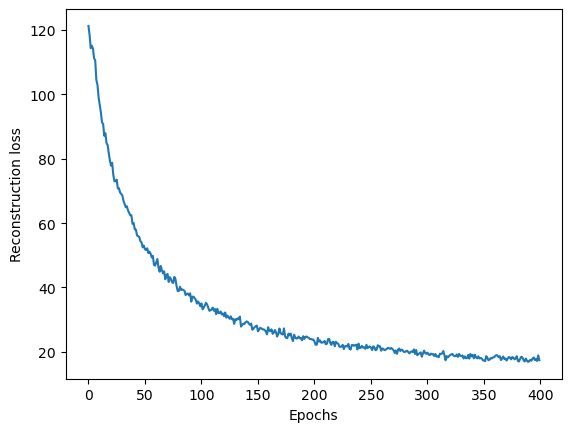

In [171]:
rbm = init_RBM(p=all_data.shape[1], q=100)
rbm_trained, losses = train_RBM(all_data, rbm, 400, 1e-1, 16)

plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Reconstruction loss")
plt.show()

In [172]:
def generer_image_RBM(rbm_trained, n_gibbs, n_images):
    """Generate image from randomly sampled data

    Parameters
    ----------
    rbm_trained : a trained RBM 

    n_gibbs : int
        number of iterations in Gibbs sampling
    n_images : int
        number of images to generate
    """
    for _ in range(n_images):
        v = np.random.binomial(1, 0.5, size=320)
        for _ in range(n_gibbs):
            _, v = CD1(v, rbm_trained)
        plt.figure()
        plt.imshow(v.reshape(20, 16))

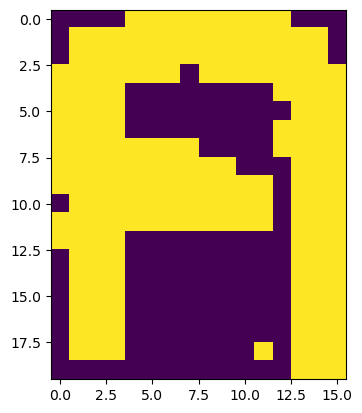

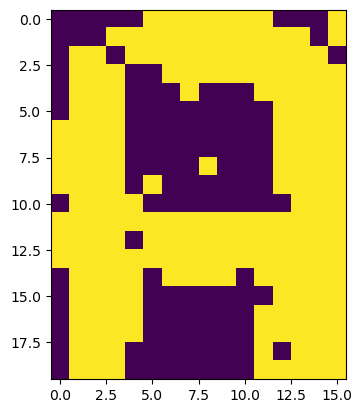

In [173]:
generer_image_RBM(rbm_trained, 200, 2)